<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/1012_MRC_Mission_3_Sparse_%26_Dense_Passage_Retrieval_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Passage Retrieval 구현하기

이번 과제에서는 3강에서 배운 **Sparse Passage Retrieval** 과 4강에서 배운 **Dense Passage Retrieval (DPR)** 을 구현해봅니다. 

Passage Retrieval 을 다시 복습해보면,
1. Query와 Passage 를 임베딩 시킨 후
2. 임베딩된 벡터들에 각각 dot product를 수행하여 유사도를 구한 후에
3. 유사도가 가장 높은 passage 들을 검색 대상으로 합니다.   

이 때 임베딩 시키는 방법에서 Sparse 와 Dense 가 나누어진 점, 다들 기억하시죠?
차근차근 구현해본 후, 전체 Wikipedia 에 대해서도 작업해봅시다.

```
🛠 Setup을 하는 부분입니다. 이전 과제에서 반복되는 부분이기 때문에 무지성 실행 하셔도 좋습니다.
💻 실습 코드입니다. 따라가면서 코드를 이해해보세요.
❓ 과제입니다. 주어진 질문과 요구사항에 맞춰서 직접 코드를 짜보세요.
```

## 🛠 초기설정

### 🛠 Requirements

In [ ]:
!pip install tqdm==4.48.0 -q
!pip install datasets==1.4.1 -q
!pip install transformers==4.5.0 -q

     |████████████████████████████████| 67 kB 3.2 MB/s 
     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 125 kB 43.9 MB/s 
     |████████████████████████████████| 243 kB 38.2 MB/s 
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 32.3 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 


### 🛠 난수 고정 및 버전 확인

In [ ]:
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    BertModel, BertPreTrainedModel,
    AdamW, get_linear_schedule_with_warmup,
    TrainingArguments,
)

In [ ]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    random.seed(random_seed)
    np.random.seed(random_seed)
    
set_seed(42) # magic number :)

In [ ]:
print ("PyTorch version:[%s]."% (torch.__version__))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu111].
device:[cuda:0].


### 🛠 데이터셋 로딩


KorQuAD 의 train 데이터를 학습 데이터로 활용

In [ ]:
from datasets import load_dataset

dataset = load_dataset("squad_kor_v1")
print("how dataset looks like")
print(dataset)
print("how dataset[0] looks like")
print(dataset['train'][0])
corpus = list(set([example["context"] for example in dataset["train"]]))
print(f"총 {len(corpus)}개의 지문이 있습니다.")

Dataset squad_kor_v1 downloaded and prepared to /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7. Subsequent calls will reuse this data.
how dataset looks like
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})
how dataset[0] looks like
{'answers': {'answer_start': [54], 'text': ['교향곡']}, 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40

### 🛠 토크나이저 준비 - Huggingface 제공 tokenizer 이용

BERT 를 encoder 로 사용하므로, KLUE에서 제공하는 `klue/bert-base` tokenizer 를 활용해봅시다. 다른 pretrained 모델을 사용하고 싶으시다면, `model_checkpoint`를 바꿔보세요 !

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

불러온 Tokenzier가 잘 작동하는지 확인해봅시다.

In [ ]:
dataset["train"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 60407
})

In [ ]:
dataset["train"][0]

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

In [ ]:
tokenized_input = tokenizer(
    dataset["train"][0]["context"],
    padding="max_length",
    truncation=True
)
#pprint(tokenizer.decode(tokenized_input["input_ids"]))

In [ ]:
tokenized_input

{'input_ids': [2, 13934, 2236, 2440, 27982, 2259, 21310, 2079, 11994, 3791, 2069, 3790, 1508, 2088, 636, 3800, 2170, 3717, 2052, 9001, 8345, 4642, 2200, 3689, 3657, 2079, 19282, 2069, 1363, 2370, 2259, 936, 2069, 554, 2259, 2062, 18, 1504, 4342, 27982, 2259, 13934, 2196, 2440, 2170, 1195, 23260, 6233, 17370, 2113, 2165, 2069, 809, 1, 3706, 2052, 2181, 8642, 2145, 7334, 2170, 4983, 2371, 4007, 1065, 5917, 2386, 2559, 4443, 2138, 4026, 2259, 11994, 3791, 2079, 15864, 2170, 5487, 2371, 4683, 3605, 18, 3819, 5986, 27135, 1376, 2645, 2203, 2292, 2079, 5872, 2200, 5986, 4152, 2252, 22835, 16706, 2052, 5485, 2205, 2259, 17087, 2079, 19282, 29, 2517, 2069, 881, 2088, 652, 2073, 23404, 2069, 1122, 2886, 13964, 16, 3982, 2052, 9944, 21, 2429, 2170, 11994, 3791, 2079, 1258, 2465, 6233, 24294, 1504, 3967, 2170, 4027, 2052, 5121, 3979, 2069, 18274, 21575, 23548, 575, 2073, 5292, 2085, 7251, 2116, 1415, 2062, 18, 3776, 2079, 942, 2286, 2446, 4196, 2079, 3640, 6509, 636, 2079, 4450, 2170, 10329, 1513

In [ ]:
pprint(tokenizer.decode(tokenized_input["input_ids"]))

('[CLS] 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. '
 '이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 [UNK] 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
 '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 '
 '받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 '
 '라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 '
 '받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 '
 '완성과 동시에 그는 이 서곡 ( 1악장 ) 을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. '
 '결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 '
 '방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 '
 '의견도 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
 '[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
 '[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
 '[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

## 💻 Ⅰ. Sparse Retriever 실습
첫 번째로 TF-IDF 를 통해 임베딩 벡터를 만들어봅시다. 이 모듈은 직접 구현할 필요 없이 `sklearn.feature_extract.text` 에서 구현된 것을 사용합시다!

더 간단하게 임베딩 벡터를 구할 수 있습니다.




### 💻 1. TF-IDF 학습하기
TF-IDF 사용법은 sklearn 홈페이지에서 확인할 수 있습니다. 제공된 링크를 읽어보시면, 아래에 작성된 코드를 쉽게 이해하실 수 있을 거에요.


*   [TF-IDF 공식 홈페이지](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
*   [TF-IDF 사용 예시](https://wikidocs.net/31698)

In [ ]:
# Huggingface의 Tokenizer를 사용하셔도 좋고
tokenizer_func = lambda x: tokenizer.tokenize(x)

# 혹은 단순 띄어쓰기 기준으로 Tokenize 하셔도 좋습니다.
# tokenizer_func = lambda x: x.split(' ')

# 어떻게 Tokenize 되었는지 확인해봅시다.
print(f"{'-'*30} 기존 문장 {'-'*30}")
pprint(corpus[20])
print(f"\n{'-'*30} Tokenize 된 문장 {'-'*30}")
pprint(" ".join(tokenizer_func(corpus[20])))

------------------------------ 기존 문장 ------------------------------
('2014년에는 6월 2일에 열린 캔자스시티 로열스와의 경기에 선발 등판하여 8이닝 동안 6피안타 1볼넷 무실점으로 완벽한 피칭을 하며 '
 '시즌 개막 후 12경기만에 10승을 달성한다. 벌리는 그 기간동안 겨우 1패에 2.10의 방어율을 기록하며 괴물같은 페이스로 자신의 첫 '
 '사이영상을 바라보는 듯 했다. 하지만, 점점 페이스가 하락하기 시작하며 사이영상경쟁에서 멀어지게 되었다. 9월 25일에는 시애틀 '
 '매리너스와의 홈경기에서 선발 등판하여 8이닝 3피안타 무실점으로 막으며 13승과 202이닝을 기록하게 되는데, 이로인해 벌리는 자신의 '
 '13년 연속 두자릿수 승-200이닝이라는 기록을 14년으로 연장한다. 이는 메이저 리그 역대 최고로 손꼽히는 제구력을 손보인 그레그 '
 '매덕스의 기록과 동률이다.')

------------------------------ Tokenize 된 문장 ------------------------------
('2014 ##년 ##에 ##는 6 ##월 2 ##일 ##에 열린 캔 ##자스 ##시티 로열 ##스 ##와 ##의 경기 ##에 선발 등판 '
 '##하여 8 ##이 ##닝 동안 6 ##피 ##안 ##타 1 ##볼 ##넷 무실점 ##으로 완벽 ##한 피칭 ##을 하 ##며 시즌 개막 '
 '후 12 ##경기 ##만 ##에 10 ##승 ##을 달성 ##한다 . 벌리 ##는 그 기간 ##동안 겨우 1 ##패 ##에 2 . 10 '
 '##의 방어 ##율 ##을 기록 ##하 ##며 괴물 ##같 ##은 페이스 ##로 자신 ##의 첫 사이 ##영상 ##을 바라보 ##는 듯 '
 '했 ##다 . 하지만 , 점점 페이스 ##가 하락 ##하기 시작 ##하 ##며 사이 ##영상 ##경 ##쟁 ##에서 멀 ##어지 ##게 '
 '되 ##었 ##다 . 9 ##월 25 ##일 ##에 ##는 시애틀 매 ##

모듈을 활용해서 `fit` 해봅시다. 과정은 어렵지 않습니다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=tokenizer_func,
    ngram_range=(1,2)
)
vectorizer.fit(corpus) #corpus = list(set([example["context"] for example in dataset["train"]]))
sp_matrix = vectorizer.transform(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors


`Vectorizer`로 임베딩을 시켜주면 (문서의 개수, 단어의 개수) 꼴의 행렬로 변환이 됩니다. 기본적으로 단어의 개수는 지정해주지 않으면 전체 단어의 개수만큼 차원이 지정됩니다. 사용되는 단어의 개수가 너무 많아서 지나치게 행렬이 희소해지면 사용이 불편하기 때문에, 필요하다면 벡터 임베딩 사이즈 또한 지정해줄 수 있습니다.

참고로 결과물이 희소행렬이기 때문에 평소에 사용되는 `numpy.ndarray`가 아닙니다. Scipy 모듈의 csr_matrix를 이용하는데 이는 아래 링크를 참고해주세요
+ [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)
+ [Scipy sparse matrix handling](https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/)

In [ ]:
type(sp_matrix)

scipy.sparse.csr.csr_matrix

In [ ]:
sp_matrix.shape # (num_passage, num_vocab)

(9606, 684272)

In [ ]:
print(sp_matrix[0])

  (0, 683997)	0.026278013230969986
  (0, 683983)	0.019056630710020225
  (0, 678921)	0.03767217999593446
  (0, 678888)	0.02545862504250149
  (0, 676620)	0.03671517304141237
  (0, 676602)	0.026671752877916587
  (0, 667528)	0.03890597654710617
  (0, 667527)	0.03527212766298383
  (0, 661711)	0.04064491511821984
  (0, 661261)	0.014225562255118201
  (0, 653779)	0.0320034993480133
  (0, 653764)	0.021159858626697472
  (0, 647791)	0.04064491511821984
  (0, 647786)	0.030170298735900554
  (0, 646010)	0.03767217999593446
  (0, 645190)	0.013400074404814381
  (0, 643475)	0.03671517304141237
  (0, 643474)	0.022910218643226638
  (0, 635490)	0.09518012925409103
  (0, 635485)	0.03333367636463755
  (0, 635484)	0.1167046380515783
  (0, 635020)	0.05962539168463901
  (0, 635017)	0.03890597654710617
  (0, 635016)	0.07186648284964156
  (0, 635014)	0.1400847590104183
  :	:
  (0, 17033)	0.01759168867116649
  (0, 14884)	0.07186648284964156
  (0, 14875)	0.05091725008500298
  (0, 14858)	0.03890597654710617
  (0, 1

In [ ]:
print(sp_matrix[1])

  (0, 677285)	0.06702601514663435
  (0, 677272)	0.05390955260385394
  (0, 677092)	0.07723567805087188
  (0, 677070)	0.07723567805087188
  (0, 677056)	0.06976816845011471
  (0, 677040)	0.06334246457306571
  (0, 677036)	0.06976816845011471
  (0, 677035)	0.24758441992311445
  (0, 675398)	0.15447135610174376
  (0, 675392)	0.11145621852517569
  (0, 674850)	0.07723567805087188
  (0, 674847)	0.04737868963685373
  (0, 672440)	0.05186141128722409
  (0, 672427)	0.04302967252206568
  (0, 659524)	0.026744719076400195
  (0, 659502)	0.01588410029816924
  (0, 652670)	0.06593777216682536
  (0, 652668)	0.05769351163104244
  (0, 646917)	0.0608147898686694
  (0, 646904)	0.04677473068114254
  (0, 638344)	0.05979474575040329
  (0, 638342)	0.05544212495817617
  (0, 628507)	0.0608147898686694
  (0, 628502)	0.05204455868901918
  (0, 624322)	0.07723567805087188
  :	:
  (0, 90235)	0.020939431596460834
  (0, 80877)	0.06976816845011471
  (0, 79104)	0.012150699350078072
  (0, 70858)	0.033042998686601634
  (0, 7072

In [ ]:
import pandas as pd
temp = pd.DataFrame(sp_matrix)

In [ ]:
temp

,0
0,"(0, 683997)\t0.026278013230969986\n (0, 683..."
1,"(0, 677285)\t0.06702601514663435\n (0, 6772..."
2,"(0, 674378)\t0.06539899776120427\n (0, 6743..."
3,"(0, 680180)\t0.026574487809087128\n (0, 680..."
4,"(0, 677941)\t0.06202924099375584\n (0, 6779..."
...,...
9601,"(0, 678039)\t0.19137460270430967\n (0, 6780..."
9602,"(0, 673232)\t0.061374989394494484\n (0, 673..."
9603,"(0, 680021)\t0.04237061382458263\n (0, 6800..."
9604,"(0, 683138)\t0.038523423223148556\n (0, 683..."


첫 번째 문장의 TF-IDF 벡터를 확인해볼까요?

In [ ]:
import pandas as pd

df = pd.DataFrame(
    sp_matrix[0].T.todense(),
    index=vectorizer.get_feature_names(),
    columns=["TF-IDF"]
)
df = df.sort_values("TF-IDF", ascending=False)
print(df.head(10))

            TF-IDF
##스 ##투스  0.202231
아우구 ##스   0.201278
아우구       0.184477
로 ##물     0.183576
##물 ##루스  0.183576
##투스      0.173397
칭호        0.140085
##루스      0.117292
카이사르      0.116705
라는 칭호     0.110146


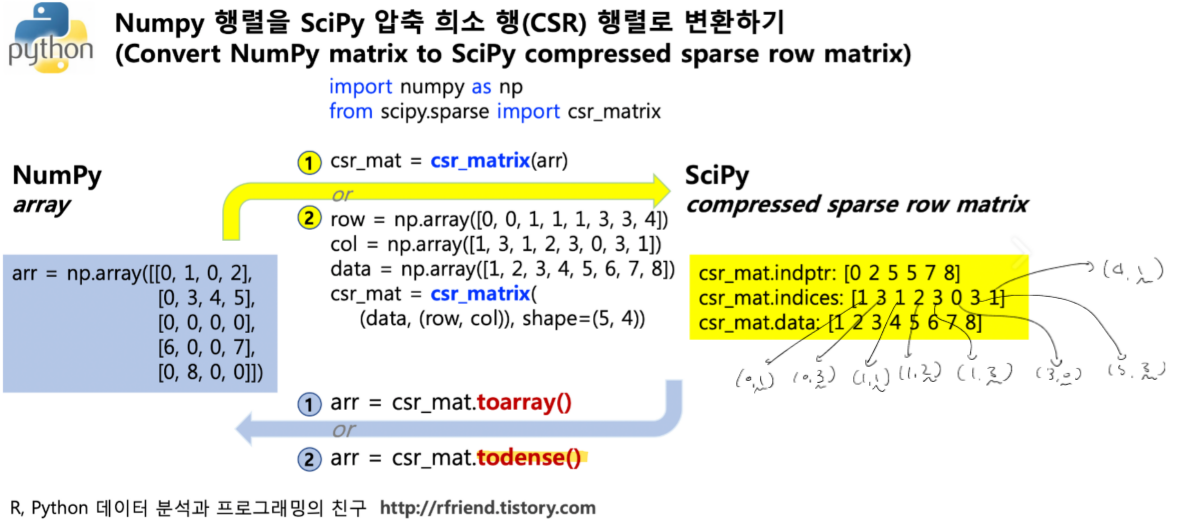

### 💻 2. Query 임베딩하기

이제 Query 를 임베딩해봅시다. 아까 사용한 `vectorizer`를 이용하면 됩니다.

In [ ]:
sample_idx = random.choice(range(len(dataset["train"])))

query = dataset["train"][sample_idx]["question"]
ground_truth = dataset["train"][sample_idx]["context"]

In [ ]:
query_vec = vectorizer.transform([query])

### 💻 3. Dot Product 를 통해 유사도 구하기
내적을 통해 주어진 Query 와 전체 Passage 사이의 유사도를 구해봅시다.
그리고 값을 내림차순으로 나열하여 높은 점수를 가진 Passage 들을 확인해봅시다.

In [ ]:
result = query_vec * sp_matrix.T
result.shape

(1, 9606)

In [ ]:
sorted_result = np.argsort(-result.data)
doc_scores = result.data[sorted_result]
doc_ids = result.indices[sorted_result]

In [ ]:
k = 5
doc_scores[:k], doc_ids[:k]

(array([0.21208908, 0.07221365, 0.0677442 , 0.05575468, 0.05302485]),
 array([2635, 7032, 1100, 5063, 4063], dtype=int32))

잘 뽑았는지 확인해봅시다.

In [ ]:
print("[Search query]\n", query, "\n")

print("[Ground truth passage]")
print(ground_truth, "\n")

for i in range(k):
    print(f"Top-{i + 1} passage with score {doc_scores[i]:.4f}")
    doc_id = doc_ids[i]
    print(corpus[doc_id], "\n")

[Search query]
 구식 군인들의 월급인 쌀에 모래와 돌멩이가 들어가있던 사건을 말미암아 일어난 사태의 이름은? 

[Ground truth passage]
1882년 6월 민영익의 귀국 권고로 일시 귀국했다가 다시 되돌아갔다. 7월 23일 한성부에서 구식 군인들의 월급으로 주는 쌀에 모래와 돌멩이 및 썩은 쌀을 주자 여기에 반발한 구식 군인들에 의해 임오군란이 일어났는데, 그는 임오군란 사태 당시 행동을 삼가고 사태의 추이를 예의주시하고 있었다. 그러다가 그해 10월 13일 박영효, 김옥균 일행이 수신사(修信使) 겸 사죄사(辭罪使)로 하는 사절단(使節團)이 파견되자, 그는 박영효와 김옥균 일행이 도쿄에 방문했을 때 사절단의 통역을 맡아보았다. 수신사는 3개월간 일본의 각 기관을 시찰하고 일본의 여·야당 정치 지도자들과 만나 면담하고 각국 사절과도 폭넓게 접촉하여 의견을 교환했다. 한학을 배워 중국어와 일본어의 기초 실력이 있었던 그는 사절단의 통역을 맡아 활약했으며, 박영효 등이 귀국할 때 일본 유학을 마치고 박영효 일행과 함께 귀국했다. 

Top-1 passage with score 0.2121
1882년 6월 민영익의 귀국 권고로 일시 귀국했다가 다시 되돌아갔다. 7월 23일 한성부에서 구식 군인들의 월급으로 주는 쌀에 모래와 돌멩이 및 썩은 쌀을 주자 여기에 반발한 구식 군인들에 의해 임오군란이 일어났는데, 그는 임오군란 사태 당시 행동을 삼가고 사태의 추이를 예의주시하고 있었다. 그러다가 그해 10월 13일 박영효, 김옥균 일행이 수신사(修信使) 겸 사죄사(辭罪使)로 하는 사절단(使節團)이 파견되자, 그는 박영효와 김옥균 일행이 도쿄에 방문했을 때 사절단의 통역을 맡아보았다. 수신사는 3개월간 일본의 각 기관을 시찰하고 일본의 여·야당 정치 지도자들과 만나 면담하고 각국 사절과도 폭넓게 접촉하여 의견을 교환했다. 한학을 배워 중국어와 일본어의 기초 실력이 있었던 그는 사절단의 통역을 맡아 활약했으며, 박영효 등이 귀국할 때 일본 유학을 마치

Ground Truth 와 동일한 Passage 가 잘 나왔나요? 제법 성능이 나쁘지 않은걸 확인할 수 있네요.   
### ❓ 제시된 두 Tokenizer 를 모두 활용해서 결과를 비교해볼까요?
위에서 제시된 Hugginface Tokenizer 와 단순 띄어쓰기로 구분된 Tokenizer 는 많은 차이를 불러올까요? 직접 코드로 구현해봅시다.

### ❓ SparseRetrieval 코드를 class로 합쳐봅시다.
Sparse Retrieval 을 잘 구현하셨나요? 하지만 코드가 너무 흩어져있어서 다시 재사용하기 많이 어렵겠네요. 이 코드들을 다른 사람들도 잘 활용할 수 있도록 모듈화를 진행해봅시다.

❗ _Hint_   
Scratch 부터 짜는게 많이 어려우신가요?

만들어야하는 기능들의 파이프라인을 나열하고 하나씩 모듈화하는 습관을 들이는 것이 좋습니다. 순서대로 생각해볼까요?

1. 데이터를 불러옵니다.
2. TF-IDF 를 Fitting 한 후 Passage 를 Transform 합니다.
3. Query 를 Fitting 한 TF-IDF 를 통해 Transform 합니다.
4. Inner dot product 를 이용해 유사도를 구하고, 내림차순을 통해 유사한 Passage 를 Retrieval 합니다.

위의 단계를 하나씩 함수로 구현한 후 class로 합치면 훨씬 쉬울 겁니다! 반드시 이 과정을 따르지 않으셔도 됩니다.

In [ ]:
# 화이팅

class TfIdfRetrieval:

    def __init__(self, tokenize_fn, data_path):

        """
        1. 여기서 Data를 불러올까요.
        """

        pass

    def get_sparse_embedding(self):

        """
        2. 여기서 주어진 전체 passage들에 대해 TF-IDF를 .fit 해줍시다.
        """

        pass

    def get_relevant_doc(self, query, k=1):

        """
        여기서
            3. Query를 받아서 TF-IDF에 Transform 시켜줍니다.
            4. 전체 Passage에 대한 유사도를 구한 후 상위 k개의 Passage를 반환합니다.
        """
        pass


In [ ]:
class TfIdfRetrieval:
    def __init__(self,
        tokenize_fn,
        data_path = "./data/wikipedia_documents.json"
    ):

        self.data_path = data_path
        with open(data_path, "r", encoding="utf-8") as f:
            wiki = json.load(f)
        self.contexts = list(dict.fromkeys([v["text"] for v in wiki.values()]))

        self.tfidfv = TfidfVectorizer(
            tokenizer=tokenize_fn,
            ngram_range=(1, 2),
            max_features=50000,
        )

    def get_sparse_embedding(self):
        print("Build Embedding")
        self.passage_embedding = self.tfidfv.fit_transform(self.contexts)

    def get_relevant_doc(self, query: str, k=1):
        query_vec = self.tfidfv.transform([query])
        result = query_vec * self.passage_embedding.T

        sorted_result = np.argsort(-result.data)
        doc_scores = result.data[sorted_result]
        doc_ids = result.indices[sorted_result]
        
        return doc_scores.tolist()[:k], doc_ids.tolist()[:k]

잘 구현하셨나요? 여러분들이 만든 클래스를 아래와 같이 활용하는데 성공하셨다면 마무리된 것입니다.


In [ ]:
tokenize_fn = lambda x: tokenizer.tokenize(x)
retriever = TfIdfRetrieval(tokenize_fn=tokenize_fn, data_path="../data/wikipedia_documents.json")

retriever.get_sparse_embedding()
query = "미국의 대통령은 누구인가?"
doc_score, doc_indices = retriever.get_relevant_doc(query, k=3)

FileNotFoundError: ignored

In [ ]:
print(f"[Search Query] {query}")

for i, idx in enumerate(doc_indices):
    print(f"Top-{i + 1}th Passage (Index {idx})")
    pprint(retriever.contexts[idx])

직접 만든 코드에 다음과 같은 추가 사항들을 고려해봅시다.   
#### ➕추가 과제: 다양한 기능 추가하기
+ 현재 코드가 **어떻게 동작하고 있는지** 궁금하지 않으신가요? 가령, 코드가 돌고는 있는데 대체 어떤 메소드를 수행 중인지, 아니면 시간이 얼마나 걸리는지 등 추가적인 정보를 Logger 에 기록하거나 Prompt 에 찍는 방향으로 더 추가해보세요 !
+ 위에서 시간을 출력하는 코드를 짜보셨다면, 이제 fitting 시간이 적지 않음을 확인할 수 있었습니다. 그리고 passage 가 자주 변경되는 것이 아니라면, 같은 기법을 사용해서 **매번 fitting 을 하는 것은 아주 비효율적**입니다. 임베딩된 passage를 따로 **저장해두고 불러와서 사용하면** 더 효율적이지 않을까요? 이 임베딩들을 `.bin` 파일로 저장하고, 만약 `.bin` 파일이 있다면 TfidfVectorizer 가 fitting 하지 않고, 이 `.bin` 파일을 불러오는 방향으로 코드를 추가해봅시다.
+ 예외 케이스가 있지 않을까요? **query가 `str` 1개가 아니라 2개 이상인 `List[str]`로 주어진 경우에는 어떻게 해야할까요?** 이 상황은 멀리 있지 않고 여러분들이 대회에서 inference 할 때도 필요한 코드입니다. 단순히 반복문을 돌릴 수 있지만, 우리는 행렬곱을 이용하고 있기 때문에 만약 query 가 여러 개면 이 행렬곱의 장점을 이용할 수 있을 것 같습니다.
    + 한 개의 query(`str`) 에 대해 유사한 passage 를 구하는 함수와
    + 여러 개의 query(`list`) 에 대해 유사한 passage 를 구하는 함수

  두 가지를 만들어봅시다. 그리고 `retrieve` 라는 함수를 만들어서 query 가 한 개인지 다수인지 체크한 후 각각의 함수를 사용해서 유사한 passage 를 찾도록 수정해봅시다.
+ 또 다른 예외케이스는 `TfidfVectorizer` 에서 생길 수 있습니다. 가령 Passage 에서 한 번도 보지 못한 단어로만 구성된 query 를 입력했다면, TF-IDF 의 특성상 이 단어는 0 으로만 임베딩될 것입니다. 전체 벡터가 0이 되면 어떻게 처리해야할까요? `assert` 를 활용해보세요!
+ 이 메소드는 어떤 parameters를 받아오고 어떤 기능을 하는지 docstring을 추가해봅시다.


요구사항이 너무 많나요? 원래 인생이 그렇습니다.

_Sparse Retrieval 과제는 두 가지 (기존과 추가 과제) 모두 예시 코드가 금요일 (10/15)제공됩니다._

## 💻 Ⅱ. Dense Retriever (BERT) 학습 시키기

이번에는 BERT 를 불러오고 학습시키는 과정을 거쳐봅시다. 시작하기 전에 어떤 과정을 거쳐야할 지 생각해봅시다.
1. 데이터셋 준비
2. 모델 준비
3. 학습하기 



### 💻 1. 데이터셋 준비하기
위에서 불러온 `datasets`를 이용해 데이터를 불러왔습니다. 하지만 이번 과제에서 passage encoder 가 학습되는 방식은 주어진 query/question에 적합한 passage 를 찾아오는 과정이 필요한데, 이 때 올바른 데이터만 이용해서 학습하는 것이 아니라, 올바르지 않은 passage 또한 학습해보는 과정을 거쳐야합니다. 이를 in-batch negative 라고 부르는데 관련된 내용은 기계독해 강의와 아래 논문을 참고해보세요.
+ [Dense Passage Retrieval](https://arxiv.org/abs/2004.04906)

#### 💻 Training Dataset 준비하기 (question, passage pairs)

실습 시간을 단축시키기 위해 일부 데이터만 활용해봅시다.




In [ ]:
sample_idx = np.random.choice(range(len(dataset["train"])), 20)
training_dataset = dataset["train"][sample_idx]

#### 💻 Negative sampling 을 위한 negative sample 들을 샘플링

주어진 query/question 에 해당하지 않는 지문들을 뽑아서 훈련데이터로 넣어줍시다. 

In [ ]:
# In-batch Negatvie로 사용할 데이터 생성
num_neg = 2

corpus = np.array(corpus) # corpus = list(set([example["context"] for example in dataset["train"]]))
p_with_neg = []

for c in training_dataset["context"]:
    while True:
        neg_idxs = np.random.randint(len(corpus), size=num_neg)
        print(p_with_neg)
        if not c in corpus[neg_idxs]:#corpus[neg_idxs] 안에  c(training_dataset["context"]중 한개)가 없으면
            p_neg = corpus[neg_idxs] #p_neg는 "corpus[neg_idx] 중 c(training_dataset["context"]중 한개)랑 안겹치는 애"이다 이제부터

            p_with_neg.append(c) #p_with_neg안에 c(training_dataset["context"]중 한개)를 추가
            p_with_neg.extend(p_neg)#p_with_neg안에 p_neg(corpus[neg_idx])를 넣는다
            print(p_with_neg)
            break

[]
['전원 공동체, 특히 그 중에서도 잉글랜드 동남부는 농노제의 작동과 지역 장원 재판소의 세금 징수를 불만스러워했다. 특히 재판소를 운영하는 영주들이 곧 원성을 사는 노동 조례나 왕실에서 제정한 법의 현장 집행자로 기능하는 경우가 잦았기 때문에 불만은 가중되었다. 촌락의 엘리트 계층 다수는 지방정부의 역할을 맡는 것을 거부했고, 재판소의 활동을 방해하기 시작했다. 재판소에 의해 몰수된 가축들은 그 주인들에 의해 ‘해방’되었고, 법관들은 폭행을 당했다. 일부는 전통적인 법을 존중하나 런던에서 내려오는 증오받는 중앙 법률에서는 분리된, 독립적인 촌락 공동체의 탄생을 지지하기 시작했다. 사학자 미리 루빈은 이 상황을, “문제는 나랏법 그 자체라기보다, 그 법을 적용하고 옹호하는 데 있었다”고 묘사한다.', '하우메는 2차례 결혼을 했다. 첫 결혼은 카스티야 왕 알폰소 8세의 딸 레오노르와 했으나 이혼했고 그 뒤 1235년에 헝가리 왕 언드라시 2세의 딸 비올란트와 결혼해 많은 자식을 두었다. 1248, 1262년 하우메는 자기 아들들에게 왕국을 나누어주었으나 결국은 치명적인 내분만 불러일으켰다. 2번째 분할에서는 맏아들 페드로에게 아라곤·발렌시아·카탈루냐를, 둘째 아들 하우메에게는 발레아레스 제도, 루시용, 그리고 페드로에게 주기로 되어 있던 봉토인 피레네 지방의 여러 백작령들을 주었다. 이러한 영토 분할로 하우메는 커다란 정치적 실수를 저질렀으며, 1258년 코르베유 조약으로 프랑스 남부의 영토에 대한 권리 주장을 포기했다. 이로 인해 카탈루냐 왕조가 전통적으로 추진했던 피레네 산맥 너머 팽창정책을 버리게 되었다. 그러나 북아프리카의 여러 소국과 관계를 발전시키고 무역을 장려하는 데는 성공했다. 또 장래를 생각해 자기 후계자인 아들 페드로를 시칠리아의 콘스탄사와 결혼시켜 이후 시칠리아 왕국을 아라곤 왕실의 영토에 통합시키는 길을 열어놓았다. 한편 용맹한 군인으로서 처남인 카스티야의 왕 알폰소 10세를 도와 무르시아 왕국에서 무어족이 일으킨 반란을 진압했으며(

[8226 3152]


In [ ]:
p_with_neg

['전원 공동체, 특히 그 중에서도 잉글랜드 동남부는 농노제의 작동과 지역 장원 재판소의 세금 징수를 불만스러워했다. 특히 재판소를 운영하는 영주들이 곧 원성을 사는 노동 조례나 왕실에서 제정한 법의 현장 집행자로 기능하는 경우가 잦았기 때문에 불만은 가중되었다. 촌락의 엘리트 계층 다수는 지방정부의 역할을 맡는 것을 거부했고, 재판소의 활동을 방해하기 시작했다. 재판소에 의해 몰수된 가축들은 그 주인들에 의해 ‘해방’되었고, 법관들은 폭행을 당했다. 일부는 전통적인 법을 존중하나 런던에서 내려오는 증오받는 중앙 법률에서는 분리된, 독립적인 촌락 공동체의 탄생을 지지하기 시작했다. 사학자 미리 루빈은 이 상황을, “문제는 나랏법 그 자체라기보다, 그 법을 적용하고 옹호하는 데 있었다”고 묘사한다.',
 '낮 시간 동안에는, 밖에 스나이퍼들이 곳곳에 배치되어 있기 때문에 민간인들은 밖으로 나가서는 안된다. 따라서, 낮에는 도구를 만들고, 자원을 모으고, 물물교환하고, 은신처를 강화하고, 음식을 요리하고 생존자들을 치료하는 시간을 갖는다. 밤에는, 밖으로 나가 정찰을 하거나 주변의 집을 약탈해 유용한 자원들을 구해 하루하루 생존을 위한 활동을 할 수 있다. 플레이어가 조작하는 게임캐릭터들은 다른 민간인 생존자NPC들을 만날 수 있고, 도와주고 치료해주고, 선물을 주거나 도둑질하고 죽일 수 있다. 플레이어는 또한 은신처안에 라디오를 설치할 수 있다. 라디오에서는 날씨주의보나 도시의 경제상황과 전쟁에 대한 유용한 정보들을 얻을 수 있어 플레이어로 하여금 적절하게 은신처를 강화하고 약탈할 수 있게 한다.',
 '제정 초기는 정부는 공화정의 형태를 가장하였다. 로마 황제는 그저 제1시민(priceps)일 뿐이었으며, 원로원은 과거 민회가 보유하던 입법권과 모든 법적 권한을 가지게 된다. 그러나 시간이 갈수록 황제의 권력은 점차 전제 권력으로 발전했으며, 원로원은 황제가 임명하는 자문 기구로 전락하였다. 로마 제국은 공화정 시대의 행정 체제를 물려받지 않았는데, 공화정에는

주어진 질문에 알맞는 지문과 올바르지 않는 지문을 모두 살펴봅시다.

In [ ]:
print("[Query Given]")
pprint(training_dataset["question"][0])

print("\n[Positive context]")
pprint(p_with_neg[0])

print("\n[Negative context]")
pprint(p_with_neg[1])
pprint(p_with_neg[2])

[Query Given]
'문제는 나랏법 자체보다는 법을 적용하고 옹호하는 데 있었다고 묘사한 사학자는?'

[Positive context]
('전원 공동체, 특히 그 중에서도 잉글랜드 동남부는 농노제의 작동과 지역 장원 재판소의 세금 징수를 불만스러워했다. 특히 재판소를 운영하는 '
 '영주들이 곧 원성을 사는 노동 조례나 왕실에서 제정한 법의 현장 집행자로 기능하는 경우가 잦았기 때문에 불만은 가중되었다. 촌락의 엘리트 '
 '계층 다수는 지방정부의 역할을 맡는 것을 거부했고, 재판소의 활동을 방해하기 시작했다. 재판소에 의해 몰수된 가축들은 그 주인들에 의해 '
 '‘해방’되었고, 법관들은 폭행을 당했다. 일부는 전통적인 법을 존중하나 런던에서 내려오는 증오받는 중앙 법률에서는 분리된, 독립적인 촌락 '
 '공동체의 탄생을 지지하기 시작했다. 사학자 미리 루빈은 이 상황을, “문제는 나랏법 그 자체라기보다, 그 법을 적용하고 옹호하는 데 '
 '있었다”고 묘사한다.')

[Negative context]
'낮 시간 동안에는, 밖에 스나이퍼들이 곳곳에 배치되어 있기 때문에 민간인들은 밖으로 나가서는 안된다. 따라서, 낮에는 도구를 만들고, 자원을 모으고, 물물교환하고, 은신처를 강화하고, 음식을 요리하고 생존자들을 치료하는 시간을 갖는다. 밤에는, 밖으로 나가 정찰을 하거나 주변의 집을 약탈해 유용한 자원들을 구해 하루하루 생존을 위한 활동을 할 수 있다. 플레이어가 조작하는 게임캐릭터들은 다른 민간인 생존자NPC들을 만날 수 있고, 도와주고 치료해주고, 선물을 주거나 도둑질하고 죽일 수 있다. 플레이어는 또한 은신처안에 라디오를 설치할 수 있다. 라디오에서는 날씨주의보나 도시의 경제상황과 전쟁에 대한 유용한 정보들을 얻을 수 있어 플레이어로 하여금 적절하게 은신처를 강화하고 약탈할 수 있게 한다.'
'제정 초기는 정부는 공화정의 형태를 가장하였다. 로마 황제는 그저 제1시민(priceps)일 뿐이었으며, 원로원은 과거 민회가 보유하던 입법권과 모든 법적

처리한 데이터를 `torch`가 처리할 수 있게 `DataLoader`로 넘겨주는 작업을 해봅시다. 기본적으로 Huggingface Pretrained 모델이 `input_ids`, `attention_mask`, `token_type_ids`를 받아주니, 이 3가지를 넣어주도록 합시다.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

q_seqs = tokenizer(
    training_dataset["question"],
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
p_seqs = tokenizer(
    p_with_neg,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

In [ ]:
max_len = p_seqs["input_ids"].size(-1)
p_seqs["input_ids"] = p_seqs["input_ids"].view(-1, num_neg + 1, max_len)
p_seqs["attention_mask"] = p_seqs["attention_mask"].view(-1, num_neg + 1, max_len)
p_seqs["token_type_ids"] = p_seqs["token_type_ids"].view(-1, num_neg + 1, max_len)

print(p_seqs["input_ids"].size())  # (num_example, pos + neg, max_len)

torch.Size([20, 3, 512])


In [ ]:
train_dataset = TensorDataset(
    p_seqs["input_ids"], p_seqs["attention_mask"], p_seqs["token_type_ids"], 
    q_seqs["input_ids"], q_seqs["attention_mask"], q_seqs["token_type_ids"]
)

### 💻 2. BERT encoder 학습시키기
1. BERT 모델을 구성한 후
2. Passage 를 임베딩하는 `p_encoder`와 Query/Question 을 임베딩하는 `q_encoder` 를 각각 선언해줍니다.
3. 두 모델을 학습시킵니다.

In [ ]:
class BertEncoder(BertPreTrainedModel):

    def __init__(self, config):
        super(BertEncoder, self).__init__(config)

        self.bert = BertModel(config)
        self.init_weights()
      
      
    def forward(self,input_ids, attention_mask=None,token_type_ids=None): 
  
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        pooled_output = outputs[1]
        return pooled_output

In [ ]:
# Pre-train된 모델을 사용해줍니다. 위에서 사용한 `model_checkpoint`를 재활용합니다.
p_encoder = BertEncoder.from_pretrained(model_checkpoint)
q_encoder = BertEncoder.from_pretrained(model_checkpoint)

if torch.cuda.is_available():
    p_encoder.cuda()
    q_encoder.cuda()

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.bi

`train` 함수를 정의한 후 `p_encoder`과 `q_encoder`를 학습시켜봅시다.


In [ ]:
def train(args, num_neg, dataset, p_encoder, q_encoder):
    batch_size = args.per_device_train_batch_size
  
    # Dataloader
    train_dataloader = DataLoader(dataset, batch_size=batch_size)

    # Optimizer
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {"params": [p for n, p in p_encoder.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": args.weight_decay},
        {"params": [p for n, p in p_encoder.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
        {"params": [p for n, p in q_encoder.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": args.weight_decay},
        {"params": [p for n, p in q_encoder.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters,lr=args.learning_rate,eps=args.adam_epsilon)
    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args.warmup_steps,
        num_training_steps=t_total
    )

    # Start training!
    global_step = 0

    p_encoder.zero_grad()
    q_encoder.zero_grad()

    p_encoder.train()
    q_encoder.train()

    torch.cuda.empty_cache()

    train_iterator = trange(int(args.num_train_epochs), desc="Epoch")
    for _ in train_iterator:

        # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        with tqdm(train_dataloader, unit="batch") as tepoch:
            for batch in tepoch:
        
                targets = torch.zeros(batch_size).long() # positive example은 전부 첫 번째에 위치하므로
                targets = targets.to(args.device)

                p_inputs = {
                    "input_ids": batch[0].view(batch_size * (num_neg + 1), -1).to(args.device),
                    "attention_mask": batch[1].view(batch_size * (num_neg + 1), -1).to(args.device),
                    "token_type_ids": batch[2].view(batch_size * (num_neg + 1), -1).to(args.device)
                }
        
                q_inputs = {
                    "input_ids": batch[3].to(args.device),
                    "attention_mask": batch[4].to(args.device),
                    "token_type_ids": batch[5].to(args.device)
                }

                del batch
                torch.cuda.empty_cache()
                # (batch_size * (num_neg + 1), emb_dim)
                p_outputs = p_encoder(**p_inputs)
                # (batch_size, emb_dim)  
                q_outputs = q_encoder(**q_inputs)

                # Calculate similarity score & loss
                p_outputs = p_outputs.view(batch_size, -1, num_neg + 1)
                q_outputs = q_outputs.view(batch_size, 1, -1)

                # (batch_size, num_neg + 1)
                sim_scores = torch.bmm(q_outputs, p_outputs).squeeze()  
                sim_scores = sim_scores.view(batch_size, -1)
                sim_scores = F.log_softmax(sim_scores, dim=1)

                loss = F.nll_loss(sim_scores, targets)
                tepoch.set_postfix(loss=f"{str(loss.item())}")

                loss.backward()
                optimizer.step()
                scheduler.step()

                q_encoder.zero_grad()
                p_encoder.zero_grad()

                global_step += 1

                torch.cuda.empty_cache()
                del p_inputs, q_inputs

    return p_encoder, q_encoder

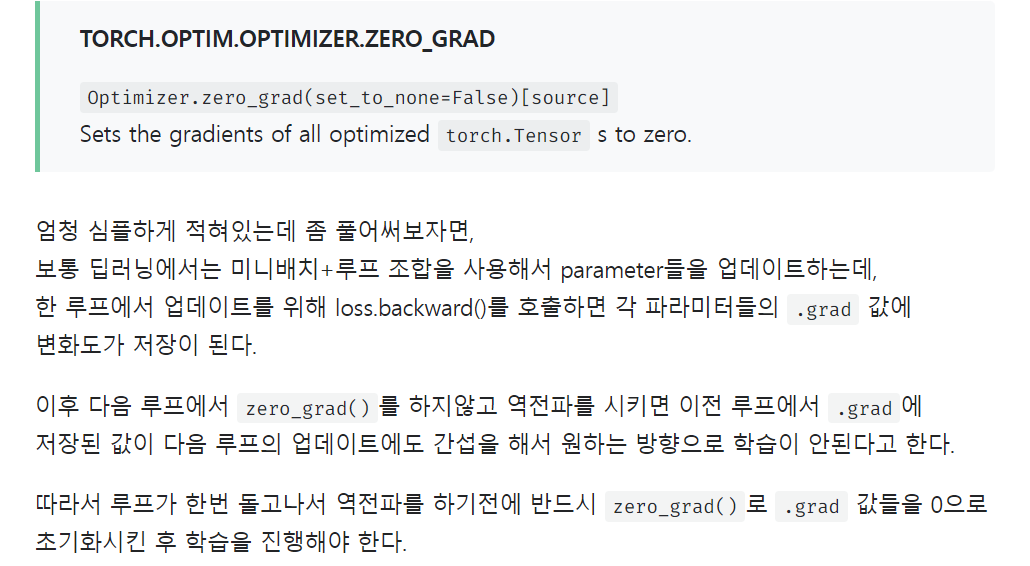

In [ ]:
args = TrainingArguments(
    output_dir="dense_retireval",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2, # 아슬아슬합니다. 작게 쓰세요 !
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
)

_혹시 CUDA 메모리 에러가 뜬다면 passage encoder 와 query encoder 를 나누지 말고 하나로 학습해보세요. `batch_size`도 변경해보세요._

In [ ]:
p_encoder, q_encoder = train(args, num_neg, train_dataset, p_encoder, q_encoder)

Epoch: 100%|██████████| 2/2 [04:41<00:00, 140.66s/it]


### 💻 3. 검증셋에 있는 Query 에 대해 passage-retrieval 해보기
이제 처음 보는 검증셋에 있는 Query 와 passage 에 대해서도 잘 작동하는지 확인해봅시다. 아래와 같은 순서로 작동해야겠죠?
1. 검증셋을 불러온다.
2. 검증셋의 query 와 passage 를 임베딩시킨다.
3. 유사도를 통해 유사한 주어진 query 에 맞는 passage 를 찾는다.

#### 💻 검증셋 불러오기

In [ ]:
valid_corpus = list(set([example["context"] for example in dataset["validation"]]))[:10]

sample_idx = random.choice(range(len(dataset["validation"])))
query = dataset["validation"][sample_idx]["question"]
ground_truth = dataset["validation"][sample_idx]["context"]

if not ground_truth in valid_corpus:
    valid_corpus.append(ground_truth)

print(f"[Selected Query]")
pprint(query)

print(f"[Ground Truth]")
pprint(ground_truth)

----- [Selected Query] -----
'SBS 연기대상에서 김태희는 무슨 상을 받았나?'

----- [Ground Truth] -----
('2001년 영화 《선물》에 이영애의 아역으로 출연하면서 연기자로 입문하였고, 2002년 독립 영화 《신도시인》에 출연했다. 이후 '
 '시트콤《레츠고》(2002), 《스크린》, 《흥부네 박터졌네》(2003)와 같은 텔레비전 드라마에 출연했다. 2003년에는 《천국의 '
 '계단》에서 악역 한유리 역할로 얼굴을 알리며 인기를 얻기 시작했고, 이 드라마로 SBS 연기대상에서 뉴스타상을 수상했다. 2004년에는 '
 '드라마 《구미호 외전》과 《러브스토리 인 하버드》에 출연했다. 하지만 이후 영화 《중천》(2006), 《싸움》(2007)에 출연했으나, '
 '모두 흥행에 실패했다. 2009년에는 시청률 30%대를 기록한 드라마 《아이리스》에서 최승희 역할을 연기해 KBS 연기대상에서 '
 '우수연기상을 수상하였다. 이후 드라마 《마이프린세스》(2011), 《나와 스타의 99일》(2012), 《장옥정 사랑에 '
 '살다》(2013)에서 주연으로 출연했고, 2015년 드라마 《용팔이》로 SBS 연기대상 최우수연기상을 수상했다.')


#### 💻 앞서 학습한 passage encoder, question encoder 을 이용해 dense embedding 생성하기

In [ ]:
with torch.no_grad():
    p_encoder.eval()
    q_encoder.eval()

    q_seqs_val = tokenizer(
        [query],
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    q_emb = q_encoder(**q_seqs_val).to("cpu")  # (num_query, emb_dim)

    p_embs = []
    for p in valid_corpus:
        p = tokenizer(
            p,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to("cuda")
        p_emb = p_encoder(**p).to("cpu").numpy()
        p_embs.append(p_emb)

p_embs = torch.Tensor(p_embs).squeeze()  # (num_passage, emb_dim)
print(p_embs.size(), q_emb.size())

torch.Size([11, 768]) torch.Size([1, 768])


#### 💻 Dot product를 통해 유사도 구하기

In [ ]:
dot_prod_scores = torch.matmul(q_emb, torch.transpose(p_embs, 0, 1))
print(dot_prod_scores.size())

rank = torch.argsort(dot_prod_scores, dim=1, descending=True).squeeze()
print(dot_prod_scores)
print(rank)

torch.Size([1, 11])
tensor([[176.3418, 147.5652, 165.1897, 177.7192, 148.4269, 156.9671, 166.3144,
         155.8632, 150.4935, 141.3773, 166.0702]])
tensor([ 3,  0,  6, 10,  2,  5,  7,  8,  4,  1,  9])


#### 💻 Top-5개의 passage를 retrieve 하고 ground truth와 비교하기

In [ ]:
k = 5
print("[Search query]\n", query, "\n")
print("[Ground truth passage]")
print(ground_truth, "\n")

for i in range(k):
  print(f"Top-{i + 1} passage with score {dot_prod_scores.squeeze()[rank[i]]}:.4f")
  pprint(valid_corpus[rank[i]])

[Search query]
 SBS 연기대상에서 김태희는 무슨 상을 받았나? 

[Ground truth passage]
2001년 영화 《선물》에 이영애의 아역으로 출연하면서 연기자로 입문하였고, 2002년 독립 영화 《신도시인》에 출연했다. 이후 시트콤《레츠고》(2002), 《스크린》, 《흥부네 박터졌네》(2003)와 같은 텔레비전 드라마에 출연했다. 2003년에는 《천국의 계단》에서 악역 한유리 역할로 얼굴을 알리며 인기를 얻기 시작했고, 이 드라마로 SBS 연기대상에서 뉴스타상을 수상했다. 2004년에는 드라마 《구미호 외전》과 《러브스토리 인 하버드》에 출연했다. 하지만 이후 영화 《중천》(2006), 《싸움》(2007)에 출연했으나, 모두 흥행에 실패했다. 2009년에는 시청률 30%대를 기록한 드라마 《아이리스》에서 최승희 역할을 연기해 KBS 연기대상에서 우수연기상을 수상하였다. 이후 드라마 《마이프린세스》(2011), 《나와 스타의 99일》(2012), 《장옥정 사랑에 살다》(2013)에서 주연으로 출연했고, 2015년 드라마 《용팔이》로 SBS 연기대상 최우수연기상을 수상했다. 

Top-1 passage with score 177.71917724609375:.4f
('2013년 12월부터는 SBS 드라마 《별에서 온 그대》에 한류 스타 천송이 역으로 출연했다. 이는 1999년 《해피투게더》 이후 14년 '
 '만의 드라마 작품으로, 이 전에 《도둑들》에서 함께 했던 김수현과 주연을 맡았다. 《별에서 온 그대》는 최고 시청률 28.1%, 평균 '
 '시청률 22.6%를 기록하며 단 한 번도 동시간대 시청률 1위를 놓친 적이 없다. 이 드라마로 2014년 5월 27일 열린 제50회 '
 '백상예술대상에서 TV 대상을 포함해 InStyle상까지 2관왕에 올랐다. 같은 해 《별에서 온 그대》로 2014년 SBS 연기대상에서 '
 '최고상인 대상과 베스트 커플상, 10대 스타상, 프로듀서상을 수상하여 4관왕에 올랐다.')
Top-2 passage w

Ground Truth와 똑같거나 비슷한 Passage가 출력됐나요? 역시 Pretrained는 강력하군요.
### ❓ Dense Retrieval 코드를 class로 합쳐봅시다.
현재 구현된 모델은 굉장히 단순히 짜여졌습니다. 이미 Pretrain된 BERT 모델을 활용했는데, 다른 PLM은 어떨까요? 이를 다시 시도해보자니 코드가 너무 셀로 흩어져있어서 재사용이 어렵네요. 우선 클래스화를 진햏한 후에, `BERT`가 아닌 다른 PLM도 활용해봅시다.

❗ _Hint_   
Scratch부터 짜는게 많이 어려우신가요?

만들어야하는 기능들의 파이프라인을 나열하고 하나씩 모듈화하는 습관을 들이는 것이 좋습니다. 순서대로 생각해볼까요?

1. Setup   
    Naive한 `Dataset`을 받아서 이를 In-Batch Negative를 활용한 후 Dataloader로 변경해주는 코드가 있어야겠죠? 클래스 내에서 활용할 수 있도록 속성(attribute)으로 만들어줍시다. 이 코드를 위에서 활용한 `train` 함수에서 조금 차용해볼까요?
2. PLM을 주어진 Passage 와 In-batch negative 기법을 활용해서 훈련합니다.   
    이는 위에서 만든 `train` 함수를 약간 응용해서 재활용합시다.
3. 훈련한 PLM 을 통해 Query 를 Transform 합니다.
4. 내적을 통해 유사도를 구하고, 내림차순을 통해 유사한 Passage 를 Retrieval 합니다.

위 4단계를 하나씩 함수로 구현한 후 Class로 합치면 훨씬 쉬울 겁니다!

In [ ]:
# 코드가 많아보이지만 주석이 더 많지롱
class DenseRetrieval:
    def __init__(self,
        args,
        dataset,
        num_neg,
        tokenizer,
        p_encoder,
        q_encoder
    ):
        """
        Arguments:
            args (Huggingface Arguments):
                세팅과 학습에 필요한 설정값을 받습니다.
            dataset (datasets.Dataset):
                Huggingface의 Dataset을 받아옵니다.
            num_neg (int):
                In-batch negative 수행시 사용할 negative sample의 수를 받아옵니다.
            tokenizer (Callable):
                Tokenize할 함수를 받아옵니다.
                아래와 같은 함수들을 사용할 수 있습니다.
                - lambda x: x.split(' ')
                - Huggingface Tokenizer
                - konlpy.tag의 Mecab
            p_encoder (torch.nn.Module):
                Passage를 Dense Representation으로 임베딩시킬 모델입니다.
            q_encoder (torhc.nn.Module):
                Query를 Dense Representation으로 임베딩시킬 모델입니다.

        Summary:
            학습과 추론에 필요한 객체들을 받아서 속성으로 저장합니다.
            객체가 instantiate될 때 in-batch negative가 생긴 데이터를 만들도록 함수를 수행합니다.
        """

        self.args = args
        self.dataset = dataset
        self.num_neg = num_neg

        self.tokenizer = tokenizer
        self.p_encoder = p_encoder.to(args.device)
        self.q_encoder = q_encoder.to(args.device)

        self.prepare_in_batch_negative(num_neg=num_neg)


    def prepare_in_batch_negative(self,
        dataset=None,
        num_neg=2,
        tokenizer=None
    ):
        """
        Arguments:
            dataset (datasets.Dataset, default=None):
                Huggingface의 Dataset을 받아오면,
                in-batch negative를 추가해서 Dataloader를 만들어주세요.
            num_neg (int, default=2):
                In-batch negative 수행시 사용할 negative sample의 수를 받아옵니다.
            tokenizer (Callable, default=None):
                Tokenize할 함수를 받아옵니다.
                별도로 받아오지 않으면 속성으로 저장된 Tokenizer를 불러올 수 있게 짜주세요.

        Note:
            모든 Arguments는 사실 이 클래스의 속성으로 보관되어 있기 때문에
            별도로 Argument를 직접 받지 않아도 수행할 수 있게 만들어주세요.
        """
        if dataset is None:
            dataset = self.dataset


    def train(self,
        args=None
    ):
        """
        Summary:
            train을 합니다. 위에 과제에서 이용한 코드를 활용합시다.
            encoder들과 dataloader가 속성으로 저장되어있는 점에 유의해주세요.
        """
        pass


    def get_relevant_doc(self,
        query,
        k=1,
        args=None
    ):
        """
        Arguments:
            query (str)
                문자열로 주어진 질문입니다.
            k (int, default=1)
                상위 몇 개의 유사한 passage를 뽑을 것인지 결정합니다.
            args (Huggingface Arguments, default=None)
                Configuration을 필요한 경우 넣어줍니다.
                만약 None이 들어오면 self.args를 쓰도록 짜면 좋을 것 같습니다.

        Summary:
            1. query를 받아서 embedding을 하고
            2. 전체 passage와의 유사도를 구한 후
            3. 상위 k개의 문서 index를 반환합니다.
        """
        pass

In [ ]:
# 데이터셋과 모델은 아래와 같이 불러옵니다.
train_dataset = load_dataset("squad_kor_v1")["train"]

# 메모리가 부족한 경우 일부만 사용하세요 !
num_sample = 1500
sample_idx = np.random.choice(range(len(train_dataset)), num_sample)
train_dataset = train_dataset[sample_idx]

args = TrainingArguments(
    output_dir="dense_retireval",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01
)
model_checkpoint = "klue/bert-base"

# 혹시 위에서 사용한 encoder가 있다면 주석처리 후 진행해주세요 (CUDA ...)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
p_encoder = BertEncoder.from_pretrained(model_checkpoint).to(args.device)
q_encoder = BertEncoder.from_pretrained(model_checkpoint).to(args.device)

Reusing dataset squad_kor_v1 (/root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/18d4f44736b8ee85671f63cb84965bfb583fa0a4ff2df3c2e10eee9693796725)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Retriever는 아래와 같이 사용할 수 있도록 코드를 짜봅시다.
retriever = DenseRetrieval(
    args=args,
    dataset=train_dataset,
    num_neg=2,
    tokenizer=tokenizer,
    p_encoder=p_encoder,
    q_encoder=q_encoder
)

retriever.train()

query = "유아인에게 타고난 배우라고 말한 드라마 밀회의 감독은?"
results = retriever.get_relevant_doc(query=query, k=5)

Iteration: 100%|██████████| 750/750 [01:34<00:00,  7.91it/s]


In [ ]:
print(f"[Search Query] {query}")

indices = result[1]
for i, idx in enumerate(indices):
    print(f"Top-{i + 1}th Passage (Index {idx})")
    pprint(retriever.contexts[idx])

[Search query]
 유아인에게 타고난 배우라고 말한 드라마 밀회의 감독은? 

[Predicted Passage]
('한편 2009년 헐리우드 메이저 영화 단독 주연으로 "닌자 어쌔신" 개봉하였고 2010년 6월 6일 아시아 한국인 최초로 미국 LA에서 '
 '열린 제 19회 "2010 엠티비 무비 어워드(MTV Movie Awards)에서 최고의 액션스타상(Biggest Badass '
 'Star)을 수상하였다. 아시아 최초 첫 단독 주연 액션스타상은 비가 최초이다. 또한 미국의 배우 안젤리나 졸리는 한 언론과의 인터뷰에서 '
 '비는 정말 대단하다며 극찬을 펼치기도 했었다. 2011년 아시아 연예인 최초로 미국 타임 세계에서 가장 영향력 있는 100인에 2회 '
 '선정되었다. 미국 타임 100인 선정은 타임 심사 위원들의 심사를 거쳐 선정하는데 가능하면 과거에 뽑힌 인물은 중복해서 선정하지 않는 게 '
 '원칙이고 인터넷 투표는 참고사항일뿐이라고 타임지는 밝혔습니다. 비는 지금까지 온라인 인기투표 리스트에 총 6회 이름이 올려줬다.[1]')


#### ➕추가 과제: 다양한 기능 추가하기
현재 코드에서 불편한 부분이 있죠. 일단 너무 많은 기능을 한 class에 넣은 것도 문제, 메소드도 한 번에 너무 다양한 기능을 하는 것이 문제입니다. 메소드 내의 기능을 쪼개서 여러 메소드로 나누거나 데이터셋을 만드는 부분 같이 큰 기능을 다른 class로 분리해봅시다. (DPR 추가 과제는 예시 코드가 제공되지 않습니다. 다양하게 활용해보세요 !)

### ❓ Sparse Retrieval과 Dense Retrieval을 둘 다 시도해보았습니다. 어떤 차이가 있을까요? 팀원들과 논의해보세요.

## ❓ 과제: Wikipedia documents에 대해 Passage Retrieval 실습하기

위에서 배운 Passage Retrieval을 Wikipedia에 있는 문서들로 진행해봅시다. 사실 위에서 두 클래스를 성공적으로 만들었다면, 데이터를 불러온 후 적용만 시키면 끝이 납니다.   
***별도의 예시코드가 제공되지 않습니다**

In [ ]:
# 츄라이 츄라이

만족스러운 결과가 나왔나요? 그렇지 않았다면 모델의 구조를 바꾸거나, 더 많은 training set으로 학습 시켜보세요 !

### ❓ Take-home Question
이 QA 모델을 배포한다고 생각해봅시다. 성능이 좋아서 점점 이용자가 많아지는 상황입니다. 만약 동시에 1000명의 이용자가 Query 를 보내면 어떻게 될까요? 전체 Passage가 100,000 개라면, 이 유사도를 계산하고 비교하는 횟수는 ... 점점 많아질 것 같네요. 이 문제는 어떻게 해결하면 좋을까요?